# Main Diffusion Script
### Imports

In [1]:
try: 
    import librosa
except:
    !pip install librosa
try:
    from audio_diffusion_pytorch import DiffusionModel, UNetV0, LTPlugin, VDiffusion, VSampler
except:
    !pip install audio-diffusion-pytorch
try: 
    import a_unet
except:
    !pip install a_unet


#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from audio_diffusion_pytorch import DiffusionModel, UNetV0, LTPlugin, VDiffusion, VSampler

from a_unet import TimeConditioningPlugin, ClassifierFreeGuidancePlugin
from a_unet.apex import XUNet, XBlock, ResnetItem as R, AttentionItem as A, CrossAttentionItem as C, ModulationItem as M, SkipCat

# Utils
import numpy as np
from numpy import ndarray
import logging
from typing import Sequence, Optional, Callable


# Base Scripts
from Libraries.Utils import *
from MainScripts.Conf import conf

### Config

General

In [28]:
remote_kernel: bool = True #Set to true if using a remote Kernel changes the file structure
model_name: str = "diffusion_full_v12"
training_data_name: str = "training_full_long"
full_model_path: str = path_to_remote_path("{}/{}".format(conf["paths"].model_path, model_name + ".pth"), remote_kernel)

Logging

In [23]:
logging_level: int = logging.INFO
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

Training Params

In [29]:
device: str = "cuda" if torch.cuda.is_available() else "cpu"
n_training_samples: int = 5600
n_validation_samples: int = 50
batch_size: int = 64
tensor_dim: list = [batch_size, 224, 512] #B, C, H = Batch, Freq bins, Time domain

learning_rate: float = 5e-4
epochs: int = 100
restart_training: bool = True
checkpoint_freq: int = 10

### Data Loading

In [30]:
file: ndarray = load_training_data(path_to_remote_path("{}/{}".format(conf["paths"].data_path, training_data_name + ".npy"), remote_kernel))
data_loader = create_dataloader(Audio_Data(file[:n_training_samples]), batch_size)
validation_dataloader = create_dataloader(Audio_Data(file[-n_validation_samples:]), batch_size)
logger.info(f"Data loaded with shape: {file.shape}")

2025-06-01 14:57:32,924 - INFO - Data loaded with shape: (5906, 224, 512)


### Setup

Model Creation

In [31]:
def UNet(dim: int, in_channels: int, channels: Sequence[int], factors: Sequence[int], items: Sequence[int], attentions: Sequence[int], cross_attentions: Sequence[int], attention_features: int, attention_heads: int, embedding_features: Optional[int] = None, skip_t: Callable = SkipCat, resnet_groups: int = 8, modulation_features: int = 1024, embedding_max_length: int = 0, use_classifier_free_guidance: bool = False, out_channels: Optional[int] = None):
    # Check lengths
    num_layers = len(channels)
    sequences = (channels, factors, items, attentions, cross_attentions)
    assert all(len(sequence) == num_layers for sequence in sequences)
    UNet = TimeConditioningPlugin(XUNet)
    if use_classifier_free_guidance:
        UNet = ClassifierFreeGuidancePlugin(UNet, embedding_max_length)

    return UNet(
        dim=dim,
        in_channels=in_channels,
        out_channels=out_channels,
        blocks=[
            XBlock(
                channels=channels,
                factor=factor,
                items=([R, M] + [A] * n_att + [C] * n_cross) * n_items,
            ) for channels, factor, n_items, n_att, n_cross in zip(*sequences)
        ],
        skip_t=skip_t,
        attention_features=attention_features,
        attention_heads=attention_heads,
        embedding_features=embedding_features,
        modulation_features=modulation_features,
        resnet_groups=resnet_groups
    )

In [32]:
u_net = UNet
u_net = DiffusionModel(
    net_t=u_net,
    dim=2,
    in_channels=416,
    channels=[128, 256, 512, 1024],
    factors=[2, 2, 2, 2],
    items=[2, 2, 2, 2],
    attentions=[0, 0, 0, 1],
    cross_attentions=[1, 1, 1, 1],
    attention_features=64,
    attention_heads=8,
    embedding_features=768,
    use_classifier_free_guidance=False,
    diffusion_t = VDiffusion,
    sampler_t = VSampler,
)

In [33]:
u_net = UNetV0
u_net = DiffusionModel(
    net_t=u_net,
    in_channels=224,
    channels=[256, 512, 512, 512, 1024, 1024, 1024],
    factors=[1, 2, 2, 2, 2, 2, 2],
    items=[1, 2, 2, 2, 2, 2, 2],
    attentions=None,
    attention_features=None,
    attention_heads=None,
    diffusion_t=VDiffusion,
    sampler_t=VSampler,
    dim=1
).to(device)


Model Loading

In [34]:
optimizer = optim.AdamW(u_net.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
start_epoch: int = 0
if os.path.exists(full_model_path):
    model = torch.load(full_model_path, map_location=device)
    u_net.load_state_dict(model["model"])
    if not restart_training:
        optimizer.load_state_dict(model["optim"])
        scheduler.load_state_dict(model["scheduler"])
        start_epoch = model.get("epoch", 0)
    logger.info(f"Model {model_name} loaded with {count_parameters(u_net)} Parameters")
else: 
    logger.info(f"Model {model_name} created with {count_parameters(u_net)} Parameters")

2025-06-01 14:57:36,011 - INFO - Model diffusion_full_v12 loaded with ~156.2M Parameters


Initiate Trainer

In [35]:
trainer = Trainer(u_net, optimizer, scheduler, device, n_dims=1)

### Training

2025-06-01 14:57:36,217 - INFO - Training started on cuda
2025-06-01 14:57:50,595 - INFO - Epoch 001: Avg. Loss: 1.59495e-01 Avg. val. Loss: 2.25509e-01 Remaining Time: 00h 23min 42s LR: 4.90000e-04 
2025-06-01 14:58:08,033 - INFO - Epoch 002: Avg. Loss: 1.56400e-01 Avg. val. Loss: 1.40535e-01 Remaining Time: 00h 25min 58s LR: 4.80200e-04 
2025-06-01 14:58:20,872 - INFO - Epoch 003: Avg. Loss: 1.55371e-01 Avg. val. Loss: 1.14619e-01 Remaining Time: 00h 24min 03s LR: 4.70596e-04 
2025-06-01 14:58:32,372 - INFO - Epoch 004: Avg. Loss: 1.59901e-01 Avg. val. Loss: 1.69502e-01 Remaining Time: 00h 22min 27s LR: 4.61184e-04 
2025-06-01 14:58:48,153 - INFO - Epoch 005: Avg. Loss: 1.55660e-01 Avg. val. Loss: 1.79170e-01 Remaining Time: 00h 22min 46s LR: 4.51960e-04 
2025-06-01 14:59:00,860 - INFO - Epoch 006: Avg. Loss: 1.58765e-01 Avg. val. Loss: 1.52741e-01 Remaining Time: 00h 22min 05s LR: 4.42921e-04 
2025-06-01 14:59:17,473 - INFO - Epoch 007: Avg. Loss: 1.55509e-01 Avg. val. Loss: 1.63484

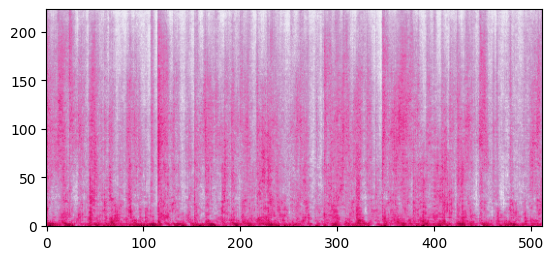

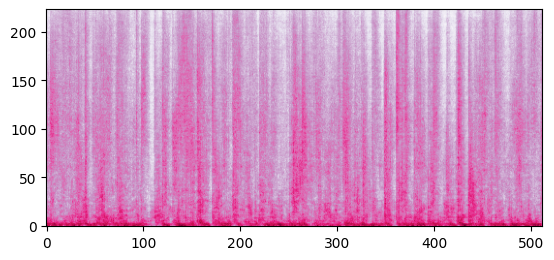

2025-06-01 14:59:54,998 - INFO - Epoch 010: Avg. Loss: 1.60349e-01 Avg. val. Loss: 1.70448e-01 Remaining Time: 00h 20min 48s LR: 4.08536e-04 
2025-06-01 15:00:16,777 - INFO - Epoch 011: Avg. Loss: 1.52729e-01 Avg. val. Loss: 2.17525e-01 Remaining Time: 00h 21min 25s LR: 4.00366e-04 
2025-06-01 15:00:38,306 - INFO - Epoch 012: Avg. Loss: 1.58054e-01 Avg. val. Loss: 1.69916e-01 Remaining Time: 00h 22min 03s LR: 3.92358e-04 
2025-06-01 15:01:03,124 - INFO - Epoch 013: Avg. Loss: 1.56644e-01 Avg. val. Loss: 1.54819e-01 Remaining Time: 00h 22min 53s LR: 3.84511e-04 
2025-06-01 15:01:31,188 - INFO - Epoch 014: Avg. Loss: 1.63604e-01 Avg. val. Loss: 1.55973e-01 Remaining Time: 00h 23min 53s LR: 3.76821e-04 
2025-06-01 15:01:53,021 - INFO - Epoch 015: Avg. Loss: 1.53289e-01 Avg. val. Loss: 1.73094e-01 Remaining Time: 00h 24min 05s LR: 3.69285e-04 
2025-06-01 15:02:06,984 - INFO - Epoch 016: Avg. Loss: 1.58021e-01 Avg. val. Loss: 1.63506e-01 Remaining Time: 00h 23min 32s LR: 3.61899e-04 
2025-0

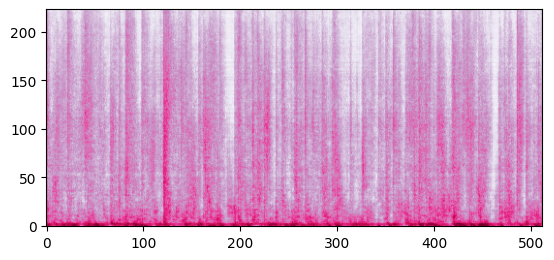

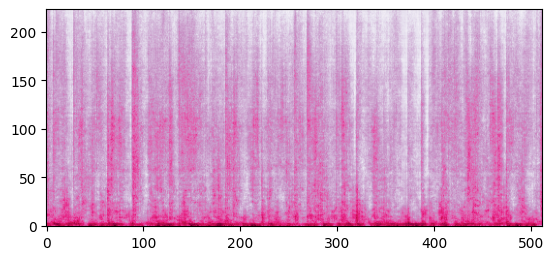

2025-06-01 15:03:20,065 - INFO - Epoch 020: Avg. Loss: 1.56007e-01 Avg. val. Loss: 8.61044e-02 Remaining Time: 00h 22min 48s LR: 3.33804e-04 
2025-06-01 15:03:37,571 - INFO - Epoch 021: Avg. Loss: 1.53158e-01 Avg. val. Loss: 1.77840e-01 Remaining Time: 00h 22min 26s LR: 3.27128e-04 
2025-06-01 15:03:49,301 - INFO - Epoch 022: Avg. Loss: 1.53391e-01 Avg. val. Loss: 1.38498e-01 Remaining Time: 00h 21min 50s LR: 3.20585e-04 
2025-06-01 15:04:05,414 - INFO - Epoch 023: Avg. Loss: 1.51800e-01 Avg. val. Loss: 1.65248e-01 Remaining Time: 00h 21min 31s LR: 3.14174e-04 
2025-06-01 15:04:17,788 - INFO - Epoch 024: Avg. Loss: 1.59671e-01 Avg. val. Loss: 1.38749e-01 Remaining Time: 00h 21min 01s LR: 3.07890e-04 
2025-06-01 15:04:30,993 - INFO - Epoch 025: Avg. Loss: 1.62377e-01 Avg. val. Loss: 1.37467e-01 Remaining Time: 00h 20min 34s LR: 3.01732e-04 
2025-06-01 15:04:51,180 - INFO - Epoch 026: Avg. Loss: 1.57280e-01 Avg. val. Loss: 1.27298e-01 Remaining Time: 00h 20min 28s LR: 2.95698e-04 
2025-0

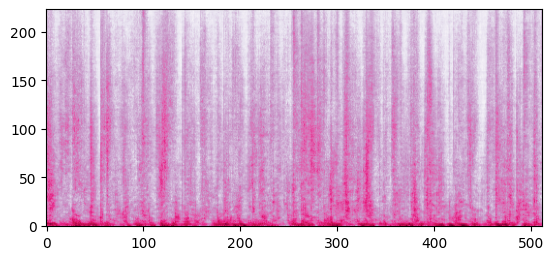

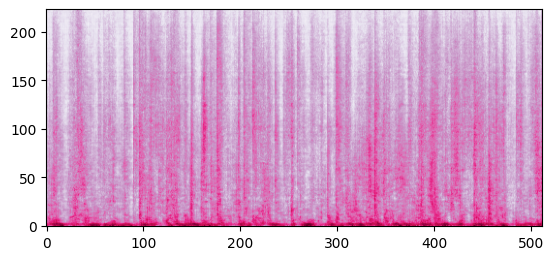

2025-06-01 15:15:17,101 - INFO - Epoch 070: Avg. Loss: 1.53890e-01 Avg. val. Loss: 1.41864e-01 Remaining Time: 00h 07min 30s LR: 1.21561e-04 
2025-06-01 15:15:35,435 - INFO - Epoch 071: Avg. Loss: 1.52725e-01 Avg. val. Loss: 1.28103e-01 Remaining Time: 00h 07min 16s LR: 1.19130e-04 
2025-06-01 15:15:46,932 - INFO - Epoch 072: Avg. Loss: 1.54951e-01 Avg. val. Loss: 1.59384e-01 Remaining Time: 00h 06min 59s LR: 1.16747e-04 
2025-06-01 15:16:04,824 - INFO - Epoch 073: Avg. Loss: 1.46690e-01 Avg. val. Loss: 1.69068e-01 Remaining Time: 00h 06min 45s LR: 1.14413e-04 
2025-06-01 15:16:16,780 - INFO - Epoch 074: Avg. Loss: 1.59387e-01 Avg. val. Loss: 1.27352e-01 Remaining Time: 00h 06min 29s LR: 1.12124e-04 
2025-06-01 15:16:31,143 - INFO - Epoch 075: Avg. Loss: 1.52065e-01 Avg. val. Loss: 1.51410e-01 Remaining Time: 00h 06min 14s LR: 1.09882e-04 
2025-06-01 15:16:43,195 - INFO - Epoch 076: Avg. Loss: 1.58413e-01 Avg. val. Loss: 1.31469e-01 Remaining Time: 00h 05min 58s LR: 1.07684e-04 
2025-0

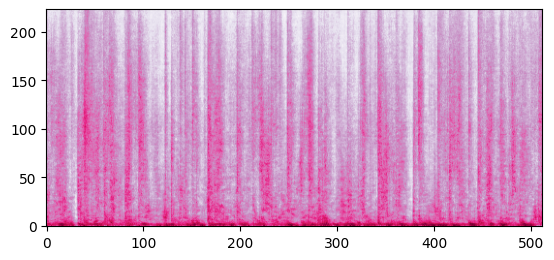

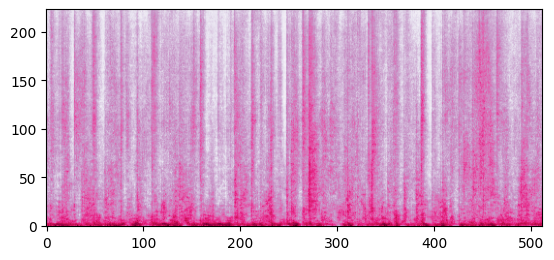

2025-06-01 15:17:32,730 - INFO - Epoch 080: Avg. Loss: 1.60953e-01 Avg. val. Loss: 1.12101e-01 Remaining Time: 00h 04min 56s LR: 9.93244e-05 
2025-06-01 15:17:46,976 - INFO - Epoch 081: Avg. Loss: 1.51408e-01 Avg. val. Loss: 1.21502e-01 Remaining Time: 00h 04min 40s LR: 9.73379e-05 
2025-06-01 15:17:58,539 - INFO - Epoch 082: Avg. Loss: 1.55646e-01 Avg. val. Loss: 1.19628e-01 Remaining Time: 00h 04min 25s LR: 9.53912e-05 
2025-06-01 15:18:15,121 - INFO - Epoch 083: Avg. Loss: 1.56781e-01 Avg. val. Loss: 1.67122e-01 Remaining Time: 00h 04min 11s LR: 9.34834e-05 
2025-06-01 15:18:30,007 - INFO - Epoch 084: Avg. Loss: 1.52423e-01 Avg. val. Loss: 1.25642e-01 Remaining Time: 00h 03min 56s LR: 9.16137e-05 
2025-06-01 15:18:45,819 - INFO - Epoch 085: Avg. Loss: 1.53445e-01 Avg. val. Loss: 1.35945e-01 Remaining Time: 00h 03min 41s LR: 8.97814e-05 
2025-06-01 15:19:08,118 - INFO - Epoch 086: Avg. Loss: 1.55465e-01 Avg. val. Loss: 1.14382e-01 Remaining Time: 00h 03min 28s LR: 8.79858e-05 
2025-0

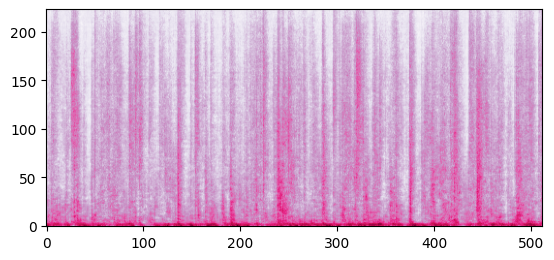

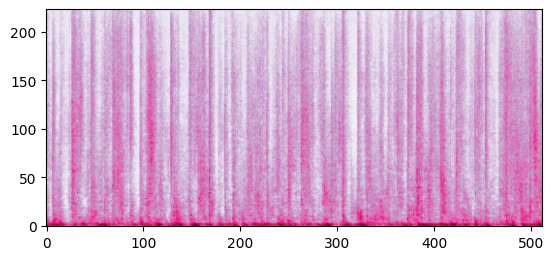

2025-06-01 15:20:06,613 - INFO - Epoch 090: Avg. Loss: 1.53106e-01 Avg. val. Loss: 1.94687e-01 Remaining Time: 00h 02min 28s LR: 8.11553e-05 
2025-06-01 15:20:22,125 - INFO - Epoch 091: Avg. Loss: 1.55473e-01 Avg. val. Loss: 1.43241e-01 Remaining Time: 00h 02min 13s LR: 7.95322e-05 
2025-06-01 15:20:38,965 - INFO - Epoch 092: Avg. Loss: 1.53065e-01 Avg. val. Loss: 1.49407e-01 Remaining Time: 00h 01min 58s LR: 7.79415e-05 
2025-06-01 15:20:51,507 - INFO - Epoch 093: Avg. Loss: 1.62334e-01 Avg. val. Loss: 1.13007e-01 Remaining Time: 00h 01min 43s LR: 7.63827e-05 
2025-06-01 15:21:03,083 - INFO - Epoch 094: Avg. Loss: 1.58203e-01 Avg. val. Loss: 1.44310e-01 Remaining Time: 00h 01min 28s LR: 7.48551e-05 
2025-06-01 15:21:17,064 - INFO - Epoch 095: Avg. Loss: 1.59948e-01 Avg. val. Loss: 1.54447e-01 Remaining Time: 00h 01min 14s LR: 7.33580e-05 
2025-06-01 15:21:28,640 - INFO - Epoch 096: Avg. Loss: 1.55178e-01 Avg. val. Loss: 1.15403e-01 Remaining Time: 00h 00min 59s LR: 7.18908e-05 
2025-0

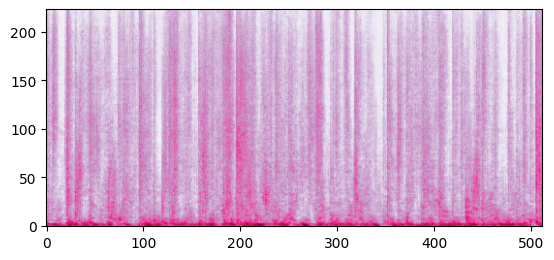

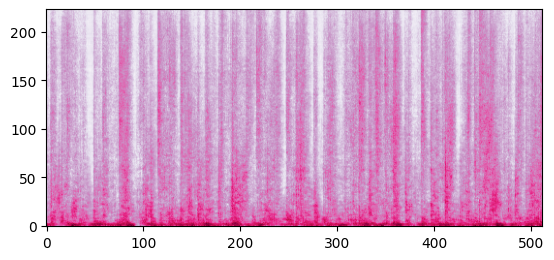

2025-06-01 15:22:25,174 - INFO - Epoch 100: Avg. Loss: 1.53697e-01 Avg. val. Loss: 1.22854e-01 Remaining Time: 00h 00min 00s LR: 6.63098e-05 


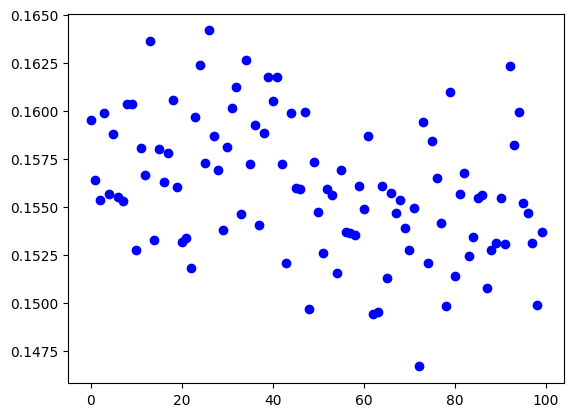

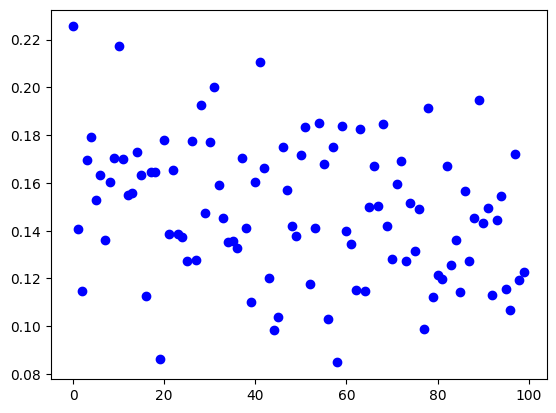

In [ ]:
train_loss, val_loss = trainer.train(train_dataset=data_loader,
            val_dataset=validation_dataloader,
            n_epochs=epochs,
            full_model_path=full_model_path,
            checkpoint_freq=checkpoint_freq,
            patience=-1,
            gradient_clip_norm=None,
            gradient_clip_val=None,
            sample_freq=10,
            #use_embed=False
            )
scatter_plot(train_loss)
scatter_plot(val_loss)

Save Model Architecture

In [10]:
trainer.save_architecture(tensor_dim, path_to_remote_path("{}/{}".format(conf["paths"].result_path, model_name + ".pt"), remote_kernel))

KeyboardInterrupt: 

### Sample

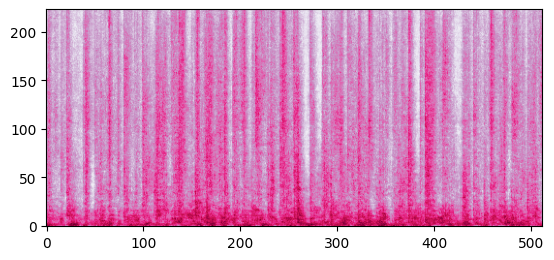

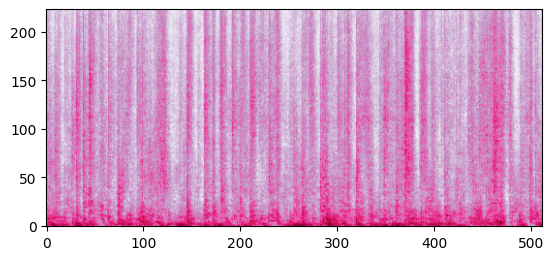

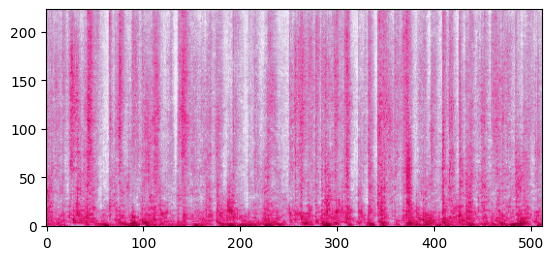

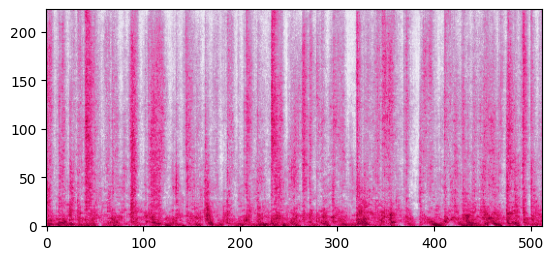

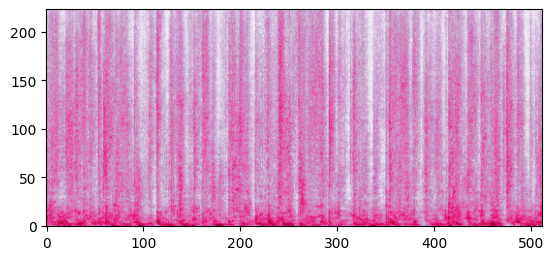

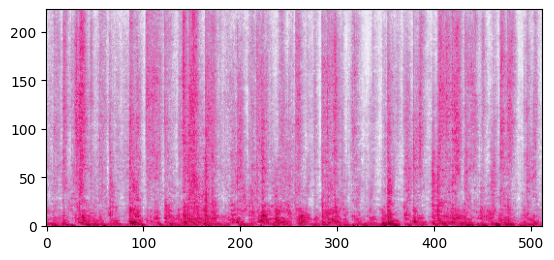

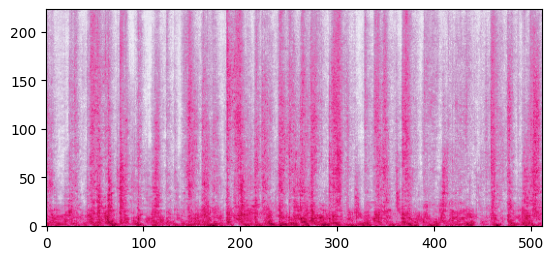

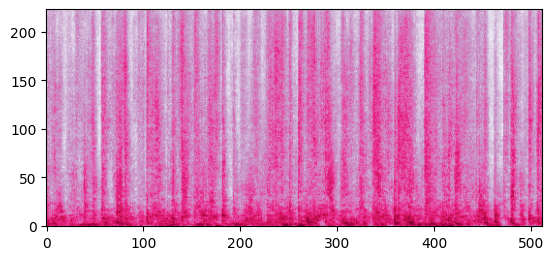

In [24]:
samples = trainer.sample(8, tensor_dim, 100, True)

Save Samples

In [25]:
trainer.save_samples(samples, path_to_remote_path("{}/{}".format(conf["paths"].result_path, "model_result"), remote_kernel))

Evaluate

In [26]:
trainer.get_audio_metrics(samples, file)

Spectral Convergence Samples/Real: 8.447, 5.416 Spectral Centroid Samples/Real: 4830.688 Hz, 5004.695 Hz
